In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.interpolate import interp1d

import pandas as pd
import numpy as np
float_formatter = "{:.7f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [2]:
model_ids = ['180703949','170803729','140624423']

In [3]:
def binning(data, bin_width=0.05):
    grb_counts = pd.DataFrame(data)
    grb_counts[0] = grb_counts[0]-grb_counts.loc[0, 0]
    first = 0; last = grb_counts.iloc[-1, 0]

    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count()
    bin_df = pd.DataFrame({'count':bin_series})
    return bin_df

def window_detection(signal, λ, σ=5, hmax=128, spacing='logarithmic'):

    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)

    max_threshold=0
    best_window=1

    for h in window_lengths:

        data = signal.rolling(window=h).mean()
        μ = data/λ

        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)


        if lr_statistic.max() > max_threshold:
            max_threshold = lr_statistic.max()
            best_window=h

    sigma_level = np.sqrt(max_threshold*2)
    return sigma_level

In [4]:
#parameters
num = 0
model_id = model_ids[num]
fluences=np.arange(start=0, stop=351, step=10)
hmax=256
bin_width=0.05
fluences

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350])

Text(0.5, 1.0, 'Simulation of GRB 180703949 with photon count 1000')

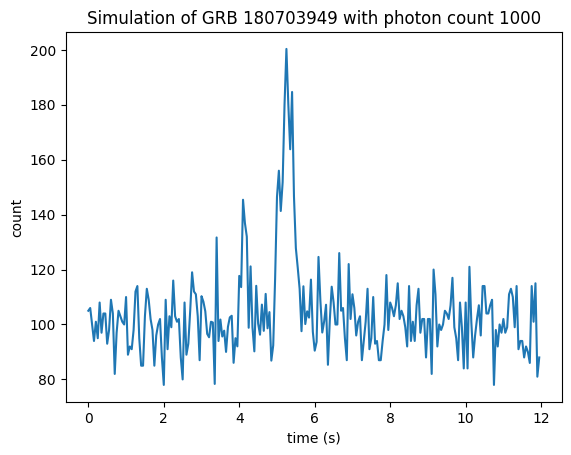

In [22]:
fluence=1000
data = pd.read_csv("simulations.csv", index_col="time") #contains simulations of each burst containing 10000 photons
background = data['background']
burst_shape = data[model_id]
grb = background + fluence/100000 * burst_shape #rescaled model of burst with background
grb.plot()
plt.xlabel('time (s)')
plt.ylabel('count')
plt.title(f'Simulation of GRB {model_id} with photon count {fluence}')
#plt.savefig(f'plots/grb{num}_pic.png', dpi=150)

In [8]:
grb

time
0.00     105.0
0.05     106.0
0.10     100.0
0.15      94.0
0.20     101.0
         ...  
11.75    114.0
11.80    101.0
11.85    115.0
11.90     81.0
11.95     88.0
Length: 240, dtype: float64

In [9]:
data

,background,180703949,170803729,140624423
time,,,,
0.00,105,0,0,0
0.05,106,0,0,0
0.10,100,0,0,0
0.15,94,0,0,0
0.20,101,0,0,0
...,...,...,...,...
11.75,114,0,0,0
11.80,101,0,0,0
11.85,115,0,0,0


In [23]:
#logarithmic

output = []

for fluence in fluences:

    grb = background + fluence/100000 * burst_shape
    output.append(window_detection(grb, λ=100, hmax=hmax, spacing='logarithmic'))

logarithmic_df = pd.DataFrame({'fluence':fluences, 'mean':output})

#exhaustive

output = []

for fluence in fluences:

    grb = background + fluence/100000 * burst_shape
    output.append(window_detection(grb, λ=100, hmax=hmax, spacing='exhaustive'))

exhaustive_df = pd.DataFrame({'fluence':fluences, 'mean':output})

In [24]:
np.array(exhaustive_df['mean'])

array([4.1826092, 4.1834872, 4.1843652, 4.1852432, 4.1861211, 4.1869991,
       4.1878770, 4.1887549, 4.1896328, 4.2185558, 4.2941719, 4.3696733,
       4.4450609, 4.5203351, 4.5954968, 4.6867359, 4.8992890, 5.1156347,
       5.3931099, 5.6700498, 5.9464582, 6.2223390, 6.4976957, 6.7725321,
       7.0468519, 7.3206587, 7.5939560, 7.8667473, 8.1390361, 8.4108259,
       8.6821199, 8.9529216, 9.2232343, 9.4930611, 9.7624055, 10.0312705])

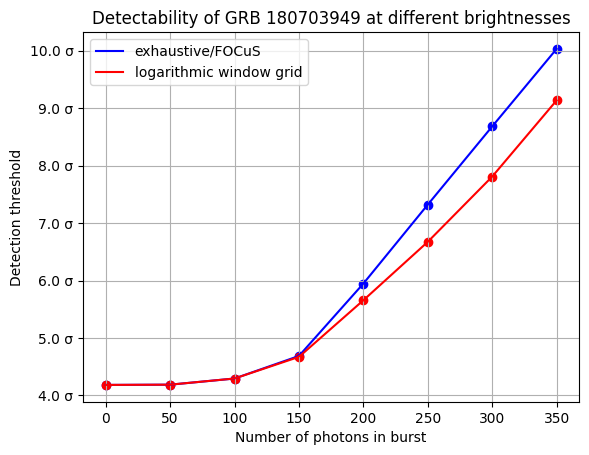

In [11]:
#plotting
interpolation='linear'

plt.scatter(exhaustive_df['fluence'], exhaustive_df['mean'], color='blue')
fit = interp1d(exhaustive_df['fluence'], exhaustive_df['mean'], kind=interpolation)
x=np.linspace(exhaustive_df['fluence'][0], exhaustive_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='blue', label='exhaustive/FOCuS')

plt.scatter(logarithmic_df['fluence'], logarithmic_df['mean'], color='red')
fit = interp1d(logarithmic_df['fluence'], logarithmic_df['mean'], kind=interpolation)
x=np.linspace(logarithmic_df['fluence'][0], logarithmic_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='red', label='logarithmic window grid')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f σ'))
plt.title(f'Detectability of GRB {model_id} at different brightnesses')
plt.ylabel('Detection threshold')
plt.xlabel('Number of photons in burst')
plt.legend()

plt.grid(True)
#plt.savefig(f'plots/grb{num}_sim.png', dpi=150)
plt.show()

In [12]:
exhaustive_df['mean']

0     4.182609
1     4.186999
2     4.294172
3     4.686736
4     5.946458
5     7.320659
6     8.682120
7    10.031270
Name: mean, dtype: float64

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math

In [6]:
def window_detection(signal, λ, hmax=128, spacing='logarithmic'):

    if hmax==None:
        hmax=len(signal)

    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)

    max_threshold=0
    best_window=1

    output=pd.DataFrame()

    for h in window_lengths:

        data = pd.Series(signal).rolling(window=h).mean()
        μ = data/λ

        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)
        sigma_level = np.sqrt(lr_statistic)
        output[f'{h}'] = sigma_level

    max_sigma = output.max(axis='columns')

    return max_sigma

In [8]:
sigma_levels = np.linspace(0, 5, 11)
λ = 100
runs = range(50)
size=2000000

data_logarithmic=pd.DataFrame(index=sigma_levels, columns=runs)

for run in runs:
    np.random.seed(run)
    signal = stats.poisson(mu=λ).rvs(size)
    significance = window_detection(signal, λ)
    for sigma_level in sigma_levels:
        run_length = np.argmax(significance>sigma_level)
        if run_length == 0:
            run_length = size
        data_logarithmic.loc[sigma_level, run] = run_length

data_logarithmic["average"] = data_logarithmic.mean(axis="columns")

data_all=pd.DataFrame(index=sigma_levels, columns=runs)
for run in runs:
    np.random.seed(run)
    signal = stats.poisson(mu=λ).rvs(size)
    significance = window_detection(signal, λ, spacing="all")
    for sigma_level in sigma_levels:
        run_length = np.argmax(significance>sigma_level)
        if run_length == 0:
            run_length = size
        data_all.loc[sigma_level, run] = run_length

data_all["average"] = data_all.mean(axis="columns")

<ipython-input-6-2a262ae3d6b4>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[f'{h}'] = sigma_level
<ipython-input-6-2a262ae3d6b4>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output[f'{h}'] = sigma_level
<ipython-input-6-2a262ae3d6b4>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

In [ ]:
λ = 100
runs = range(20)
size=20000000

data_all=pd.DataFrame(index=sigma_levels, columns=runs)
for run in runs:
    np.random.seed(run)
    signal = stats.poisson(mu=λ).rvs(size)
    significance = window_detection(signal, λ, spacing="all")
    for sigma_level in sigma_levels:
        run_length = np.argmax(significance>sigma_level)
        if run_length == 0:
            run_length = size
        data_all.loc[sigma_level, run] = run_length

data_all["average"] = data_all.mean(axis="columns")

Text(0.5, 1.0, 'Average run length comparison at different sigma levels')

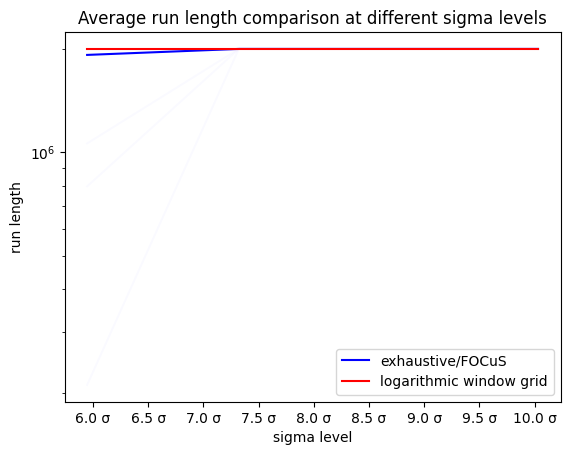

In [19]:
for run in runs:
    plt.plot(data_all[run], color="blue", alpha=0.02)
    plt.plot(data_logarithmic[run], color="red", alpha=0.02)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f σ'))
plt.plot(data_all["average"], color="blue", alpha=1, label="exhaustive/FOCuS")
plt.plot(data_logarithmic["average"], color="red", alpha=1, label="logarithmic window grid")
plt.yscale("log")
plt.xlabel("sigma level")
plt.ylabel("run length")
plt.legend()
plt.title("Average run length comparison at different sigma levels")

In [18]:
data_all['average']

4.0      5623.34
4.1      8449.74
4.2     12277.34
4.3     18940.88
4.4     24567.46
4.5     48482.06
4.6     64692.74
4.7    108519.70
4.8    171507.50
4.9    278664.94
5.0    405373.90
Name: average, dtype: float64

In [22]:
exhaustive_df

,fluence,mean
0,0,4.182609
1,100,4.294172
2,200,5.946458
3,400,11.368514


In [18]:
import numpy as np

def e_detector_cusum(data, lambda_val):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lambda_val, np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lambda_val) - l + lambda_val
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lambda_val) - l + lambda_val

    return np.apply_along_axis(np.max, 0, E)




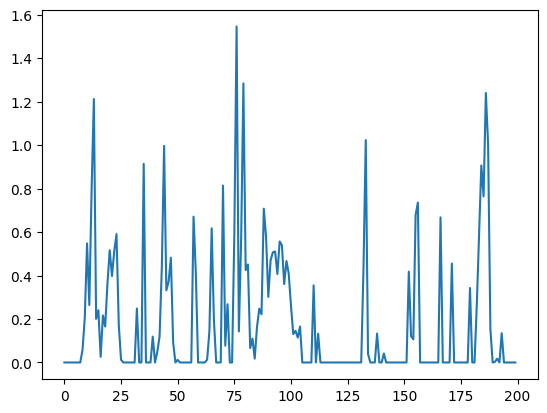

In [23]:
data = np.random.poisson(300, 200)

# Plot the result
plt.plot(e_detector_cusum(data, 300))
plt.show()

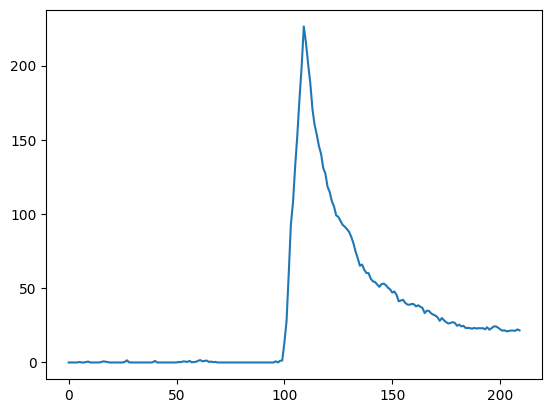

In [24]:
data = np.concatenate((np.random.poisson(30, 100), np.random.poisson(80, 10), np.random.poisson(30, 100)))

# Plot the result
plt.plot(e_detector_cusum(data, 30))
plt.show()

In [25]:
import numpy as np

def e_detector_sr(data, lambda_val):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lambda_val, np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lambda_val) - l + lambda_val
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lambda_val) - l + lambda_val

    return np.apply_along_axis(np.sum, 0, E)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


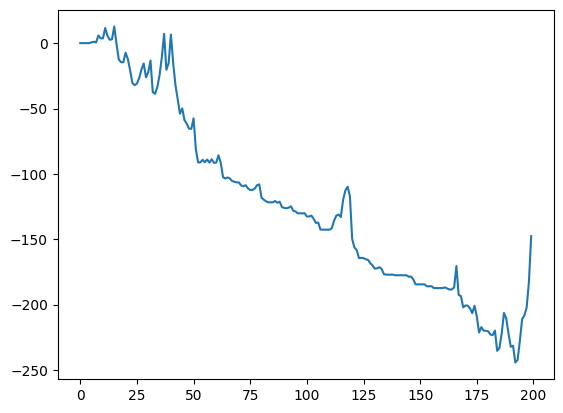

In [27]:
data = np.random.poisson(300, 200)

# Plot the result
plt.plot(e_detector_sr(data, 300))
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


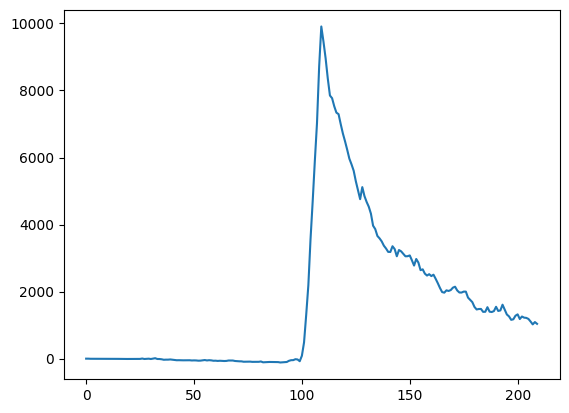

In [29]:
data = np.concatenate((np.random.poisson(30, 100), np.random.poisson(80, 10), np.random.poisson(30, 100)))

# Plot the result
plt.plot(e_detector_sr(data, 30))
plt.show()

In [31]:
import numpy as np

cusum = np.zeros((17, 3))
sr = np.zeros((17, 3))
id = np.arange(0, 170, 10)  # Adjusted to match R's seq function behavior

for i in range(17):
    for j in range(3):
        grb = data['background'] + id[i] / 100000 * data.iloc[:, j + 2]
        cusum[i, j] = max(e_detector_cusum(grb, 100))
        sr[i, j] = max(e_detector_sr(grb, 100))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices